# Optimal strategy over yaw angles
This notebook examines the optimal turbine control strategy (maximising $C_P$) for various yaw angles. The IEA15MW reference turbine is modelled using BEM methods to determine the optimal setpoints (tip speed ratio, pitch angle).

In [5]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

rootdir = Path(os.getcwd()).parent
figdir = rootdir / Path("fig")
figdir.mkdir(exist_ok=True, parents=True)

cache_fn = rootdir / "cache/tsr_pitch_yaw.csv"
# out_fn = figdir / "optimal_over_yaw.png"


pl.Config.set_tbl_cols(20)


df = pl.read_csv(cache_fn)
print(df["data_type"].unique().to_numpy())

strategies_to_plot = {
    "optimal": df.filter(pl.col("data_type") == "optimal"),
    "constant_tsr": df.filter(pl.col("data_type") == "constant_tsr"),
    "k-omega": df.filter(pl.col("data_type") == "k-omega"),
}

['constant_tsr' 'zero_yaw_Ctprime_trajectory' 'contour' 'optimal'
 'Ctprime_trajectory' 'k-omega']


In [6]:
to_plot = [
    "optimal",
    "constant_tsr",
    "k-omega",
]
CP_OPT = df.filter(pl.col("data_type") == "optimal").filter(pl.col("yaw") == 0)["Cp"][0]


df_cp = df.filter(pl.col("data_type").is_in(to_plot)).pivot(
    index="yaw", columns="data_type", values="Cp", aggregate_function=None
)
df_ct = df.filter(pl.col("data_type").is_in(to_plot)).pivot(
    index="yaw", columns="data_type", values="Ctprime", aggregate_function=None
)

df_cp_norm = df_cp.select(pl.col("yaw"), pl.all().exclude("yaw") / pl.col("k-omega"))
df_ct_per_cp = df_ct / df_cp
df_both = df.filter(pl.col("data_type").is_in(to_plot)).pivot(
    index="yaw",
    columns="data_type",
    values=["Cp", "Ct", "Ctprime", "u4"],
    aggregate_function=None,
)
df_cp = df_cp.with_columns(
    (CP_OPT * np.cos(np.deg2rad(pl.col("yaw"))) ** 3).alias("cos3")
).with_columns((CP_OPT * np.cos(np.deg2rad(pl.col("yaw"))) ** 2).alias("cos2"))
df_both.columns

['yaw',
 'Cp_data_type_constant_tsr',
 'Cp_data_type_optimal',
 'Cp_data_type_k-omega',
 'Ct_data_type_constant_tsr',
 'Ct_data_type_optimal',
 'Ct_data_type_k-omega',
 'Ctprime_data_type_constant_tsr',
 'Ctprime_data_type_optimal',
 'Ctprime_data_type_k-omega',
 'u4_data_type_constant_tsr',
 'u4_data_type_optimal',
 'u4_data_type_k-omega']

### Read and print data set

## Setpoints versus yaw

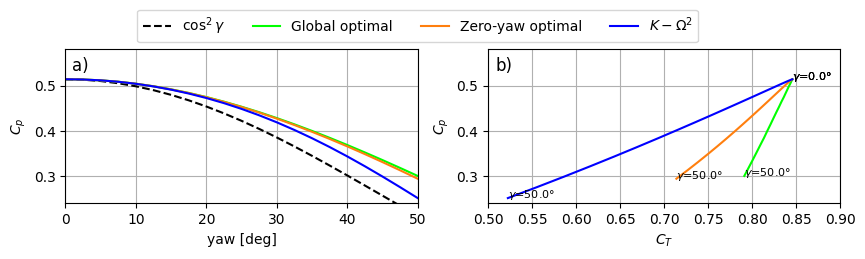

In [39]:
colors = {
    "optimal": "lime",
    "constant_tsr": "tab:orange",
    "k-omega": "blue",
}
labels = {
    "optimal": "Global optimal",
    # "constant_tsr": "Constant $\lambda$",
    "constant_tsr": "Zero-yaw optimal",
    "k-omega": "$K - \Omega^2$",
}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 2))
# Plot cos^2
axes[0].plot(df_cp["yaw"], df_cp["cos2"], "--k", label="$\cos^2\gamma$")

# Plot BEM lines
for key in to_plot:
    axes[0].plot(df_cp["yaw"], df_cp[key], c=colors[key], label=labels[key])
    axes[1].plot(
        df_both[f"Ct_data_type_{key}"],
        df_both[f"Cp_data_type_{key}"],
        c=colors[key],
        label=labels[key],
    )

# Label yaw angles on right figure
for key in to_plot:
    for yaw, Cp, Ct in (
        df_both.filter(pl.col("yaw").is_in([0, 50]))
        .select("yaw", f"Cp_data_type_{key}", f"Ct_data_type_{key}")
        .iter_rows()
    ):
        axes[1].text(Ct, Cp, f"$\gamma$={yaw}°", ha="left", fontsize=8)

# Label axes
axes[0].set_xlabel("yaw [deg]")
axes[0].set_ylabel("$C_p$")

axes[1].set_xlabel("$C_T$")
axes[1].set_ylabel("$C_p$")

# Titles (as text)
axes[0].text(
    0.02, 0.95, "a)", fontsize=12, ha="left", va="top", transform=axes[0].transAxes
)
axes[1].text(
    0.02, 0.95, "b)", fontsize=12, ha="left", va="top", transform=axes[1].transAxes
)

[ax.grid() for ax in axes]

# Set limits
axes[0].set_xlim(0, 50)
axes[1].set_xlim(0.5, 0.9)
[ax.set_ylim(0.24, 0.58) for ax in axes]


axes[0].legend(loc="lower center", ncol=4, bbox_to_anchor=(1, 1.0))
plt.savefig(figdir / "optimal_over_yaw_Ct_swapped.png", dpi=300, bbox_inches="tight")

## Value to mention in abstract

In [11]:
df.select("data_type", "yaw", "Cp").with_columns(
    (np.log(pl.col("Cp") / CP_OPT) / np.log(np.cos(np.deg2rad(pl.col("yaw"))))).alias(
        "exponent"
    )
).filter(pl.col("yaw") != 0).filter(pl.col("data_type").is_in(to_plot)).groupby(
    "data_type"
).agg(
    pl.col("exponent").mean()
)

/home/jaime/Repositories/Torque2024_AD_vs_BEM/.venv/lib/python3.8/site-packages/polars/series/series.py:1092: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/home/jaime/Repositories/Torque2024_AD_vs_BEM/.venv/lib/python3.8/site-packages/polars/series/series.py:1092: RuntimeWarning: invalid value encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


data_type,exponent
str,f64
"""optimal""",1.243334
"""constant_tsr""",1.261908
"""k-omega""",1.393824


In [12]:
ctprime_of_interest = [2, 2.5, 3]
df_new_grid = pl.DataFrame(dict(Ctprime=ctprime_of_interest))

_df = df.filter(pl.col("data_type") == "constant_tsr")
df_new_grid.join(_df, on="Ctprime", how="outer").sort("Ctprime").with_columns(
    pl.all().interpolate("linear")
).filter(pl.col("Ctprime").is_in(ctprime_of_interest))

Ctprime,pitch,tsr,yaw,Cp,Ct,a,u4,v4,data_type
f64,f64,f64,f64,f64,f64,f64,f64,f64,str
2.0,-2.8712,8.589028,26.25,0.446459,0.807249,0.292073,0.429846,-0.089221,null
2.5,-2.8712,8.589028,41.25,0.357172,0.754767,0.275208,0.47931,-0.124362,null
3.0,-2.8712,8.589028,48.75,0.303588,0.719996,0.262973,0.511536,-0.135276,null
